## Load libraries

In [1]:
library(tidyverse)
library(tibbletime)
library(anomalize)
library(lubridate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘tibbletime’

The following object is masked from ‘package:stats’:

    filter


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



## Load the Data

In [120]:
tb = read_csv("../../output/NYCHA_TS.csv")
tb = select(tb, c('Building_Meter', 'Month', 'Imputed_KWH'))

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  Building_Meter = col_character(),
  Month = col_date(format = ""),
  Month_Type = col_character(),
  `Month_#_Days` = col_double(),
  Prorated_Days = col_double(),
  Gap_Days = col_double(),
  Gap_Type = col_character(),
  Prorated_KWH = col_double(),
  Imputed_KWH = col_double()
)


## Explor Missing Values per account

In [121]:
# tb <- na_if(tb, 0)

accounts = tb %>% group_by(Building_Meter) 
# accounts <- accounts %>% summarise(counts = n(), na_counts = sum(is.na(Imputed_KWH)))
accounts <- accounts %>% summarise(counts = n(), na_counts = sum(Imputed_KWH == 0))
accounts <- filter(accounts, counts - na_counts >= 50)
accounts <- mutate(accounts, na_perc = na_counts/counts)

dim(accounts)

[1] 1916    4

In [133]:
data.frame(accounts)

Building_Meter,counts,na_counts,na_perc
1.0 - BLD 01_7836716,103,13,0.126213592
1.0 - BLD 01_7838586,103,16,0.155339806
1.0 - BLD 02_7694040,103,13,0.126213592
1.0 - BLD 03_7177432,103,14,0.135922330
1.0 - BLD 04_7381828,103,13,0.126213592
1.0 - BLD 05_6889487,103,13,0.126213592
1.0 - BLD 06_6469176,103,13,0.126213592
1.0 - BLD 07_7006908,73,1,0.013698630
10.0 - BLD 01_7864550,102,2,0.019607843
10.0 - BLD 02_7864551,102,2,0.019607843


In [152]:
write.table(accounts$Building_Meter, file = "../../output/NYCHA_Accounts_More_Than_50_Months.csv")

In [153]:
df = read.csv("../../output/NYCHA_Accounts_More_Than_50_Months.csv")

In [154]:
head(df)

x
1 1.0 - BLD 01_7836716
2 1.0 - BLD 01_7838586
3 1.0 - BLD 02_7694040
4 1.0 - BLD 03_7177432
5 1.0 - BLD 04_7381828
6 1.0 - BLD 05_6889487


## Explore the Anomalize package

#### plotting configuration for the flagged anomalies

In [4]:
# ploting function for anomaly plots
ggsetup <- function(data) {
    data %>%
        ggplot(aes(rank, value, color = outlier)) +
        geom_point() +
        geom_line(aes(y = limit_upper), color = "red", linetype = 2) +
        geom_line(aes(y = limit_lower), color = "red", linetype = 2) +
        geom_text(aes(label = index), vjust = -1.25) +
        theme_bw() +
        scale_color_manual(values = c("No" = "#2c3e50", "Yes" = "#e31a1c")) +
        expand_limits(y = 13) +
        theme(legend.position = "bottom")
}

### Example 1 - Account with no missing data

#### Method 1: STL + IQR

In [71]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr', alpha = 0.05) %>%
    time_recompose()

# ts_anomalized %>% glimpse()

ts_anomalized$Month_Value = format(ts_anomalized$Month,"%m")

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


#### Plot the decomposed results with outliers

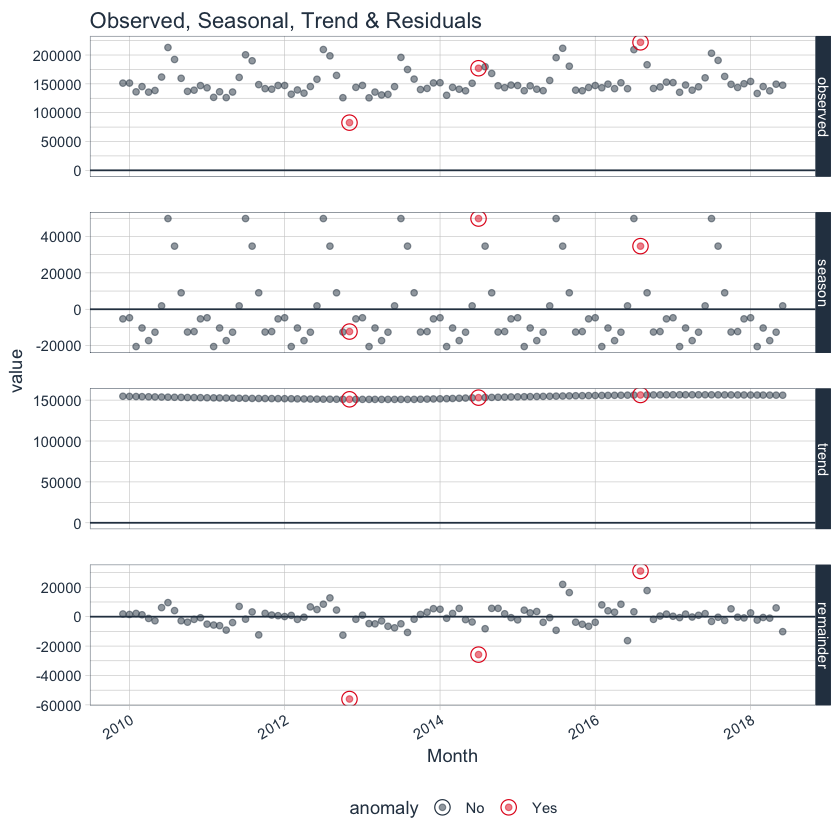

In [72]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Observed, Seasonal, Trend & Residuals") 
p1

#### Plot the anomalies by its rank of deviation

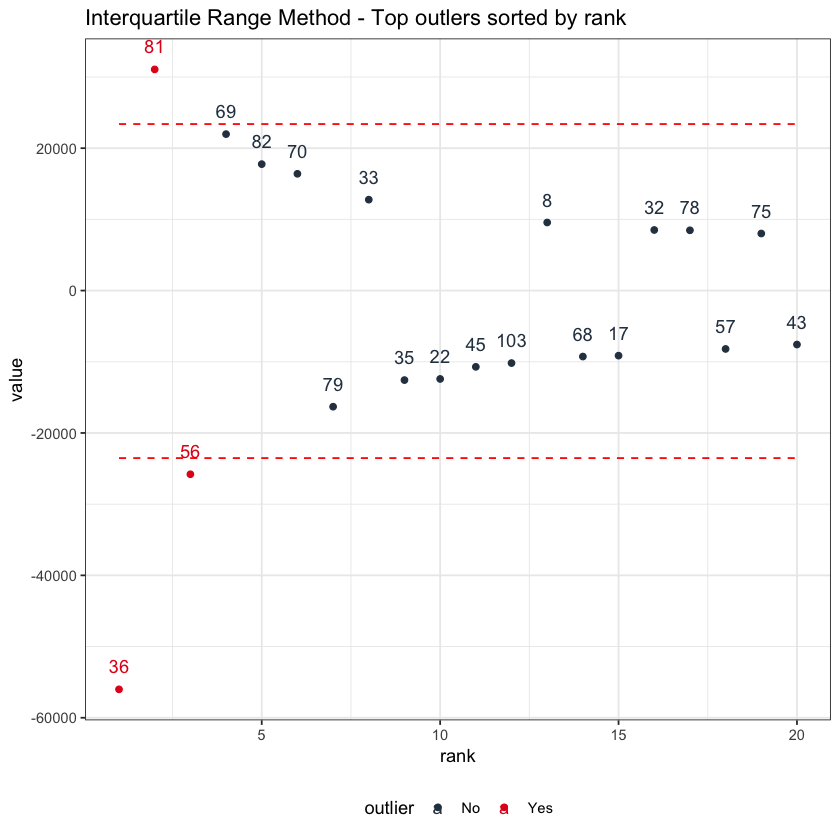

In [73]:
outliers <- iqr(ts_anomalized$remainder, verbose = TRUE)$outlier_report
outliers %>% 
    ggsetup() +
    ggtitle("Interquartile Range Method - Top outlers sorted by rank") 

In [74]:
a <- ts_anomalized[filter(outliers, outlier == 'Yes')$index, c(1,2,4,6,5,7)]

rename(a, Calendar_Month = Month, Observed = observed, Trend = trend, Seasonal = season, Residual = remainder)

Building_Meter,Calendar_Month,Observed,Trend,Seasonal,Residual
165.0 - BLD 03_90327795,2012-11-01,82710.3,150984.3,-12265.34,-56008.64
165.0 - BLD 03_90327795,2016-08-01,222030.0,156279.1,34686.26,31064.60
165.0 - BLD 03_90327795,2014-07-01,177073.8,153031.5,49841.16,-25798.86


#### Method 2: Twitter + GESD

In [109]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "twitter", merge = TRUE) %>%
    anomalize(remainder, method = 'gesd') %>%
    time_recompose()

# ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


The Twitter decomposition method returns more outilers than the original STL method.

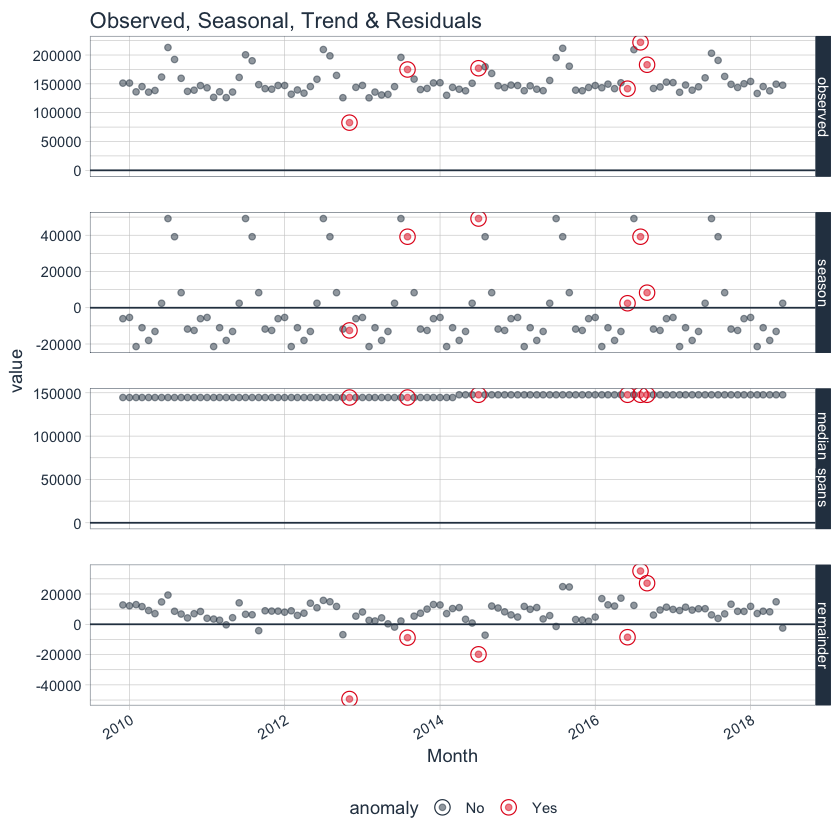

In [110]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Observed, Seasonal, Trend & Residuals") 

p1

#### Plot the anomalies by its rank of deviation

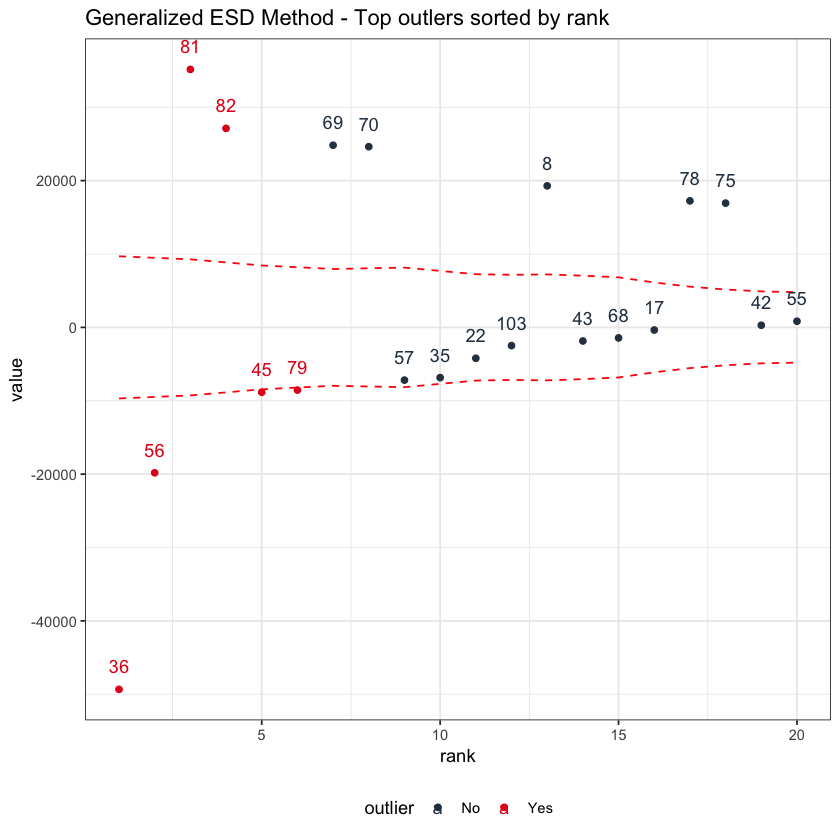

In [111]:
outliers <- gesd(ts_anomalized$remainder, alpha = 0.05, max_anoms = 0.2, verbose = TRUE)$outlier_report
outliers %>% 
    ggsetup() +
    ggtitle("Generalized ESD Method - Top outlers sorted by rank") 

In [112]:
filter(outliers, outlier == 'Yes')

rank,index,value,limit_lower,limit_upper,outlier,direction
1,36,-49329.365,-9690.167,9690.167,Yes,Down
2,56,-19817.651,-9480.988,9480.988,Yes,Down
3,81,35159.351,-9271.922,9271.922,Yes,Up
4,82,27126.328,-8855.808,8855.808,Yes,Up
5,45,-8836.832,-8440.344,8440.344,Yes,Down
6,79,-8542.575,-8200.526,8200.526,Yes,Down


In [115]:
b <- ts_anomalized[filter(outliers, outlier == 'Yes')$index, c(1,2,4,6,5,7)]

b <- rename(b, Calendar_Month = Month, Observed = observed, Trend = median_spans, Seasonal = season, Residual = remainder)

In [119]:
b[c(1,3,4,2,5,6), c(1,2,4, 3, 5, 6)]

Building_Meter,Calendar_Month,Trend,Observed,Seasonal,Residual
165.0 - BLD 03_90327795,2012-11-01,144548.5,82710.3,-12508.822,-49329.365
165.0 - BLD 03_90327795,2016-08-01,147692.3,222030.0,39178.342,35159.351
165.0 - BLD 03_90327795,2016-09-01,147692.3,183134.8,8316.164,27126.328
165.0 - BLD 03_90327795,2014-07-01,147692.3,177073.8,49199.121,-19817.651
165.0 - BLD 03_90327795,2013-08-01,144548.5,174890.0,39178.342,-8836.832
165.0 - BLD 03_90327795,2016-06-01,147692.3,141632.4,2482.649,-8542.575


### Questions:

- Why does the GESD test return outliers in this order? 
- Does the Anomalize package implemented the GESD test as suggested in the Twitter paper, using MAD instead of Median?

### Method 3: XmR chart

In [83]:
tb_all <- tb

In [85]:
account = '165.0 - BLD 03_90327795'

In [86]:
tb =  select(filter(tb_all, Building_Meter == account), 'Month', 'Imputed_KWH')

In [87]:
ts_anomalized <- tb %>%
  time_decompose(Imputed_KWH, method = "STL", merge = TRUE)
ts_anomalized <- rename(ts_anomalized, Residual = remainder)


Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


In [91]:
library(ggQC)
library(gridExtra)


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



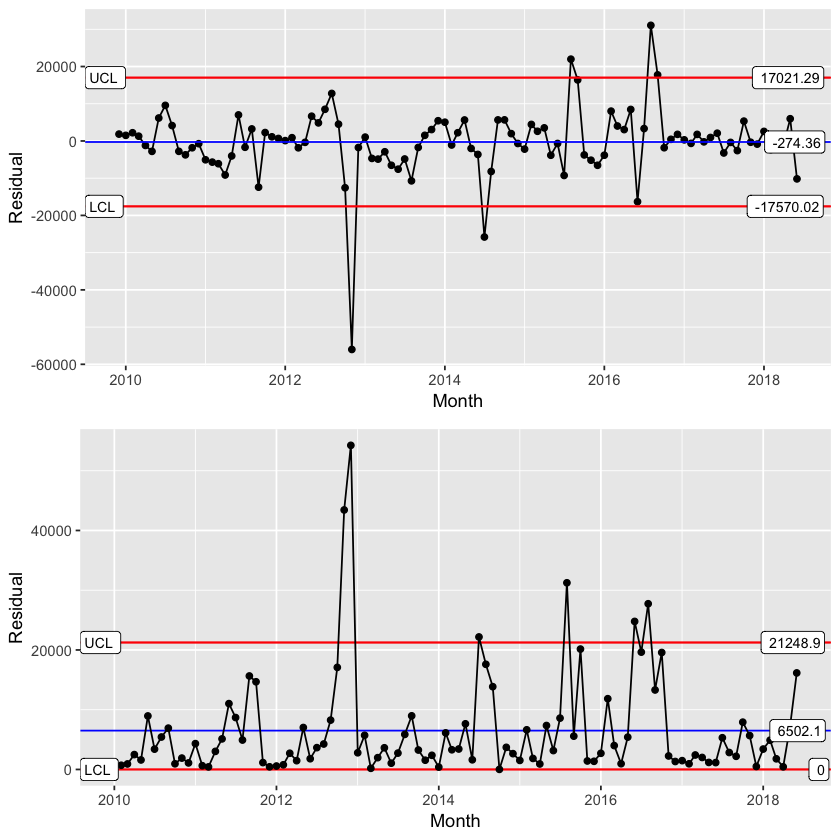

In [92]:
x_Plot <- ggplot(ts_anomalized, aes(x = Month, y = Residual)) + geom_point() + geom_line() + 
  stat_QC(method = 'XmR', auto.label = T, label.digits = 2, show.1n2.sigma = F) 

mR_Plot <- ggplot(ts_anomalized, aes(x = Month, y = Residual)) + stat_mR() + stat_QC_labels(method="mR")

grid.arrange(x_Plot, mR_Plot, nrow=2)

In [93]:
# summarize the control limits
ctrl_limits <- QC_Lines(data = ts_anomalized$Residual, method = "XmR")     
ts_anomalized <- cbind(ts_anomalized, ctrl_limits)

cal_dev <- function(x) {
  if (x$Residual < x$xBar_one_LCL) {
    return(x$xBar_one_LCL - x$Residual)
  } else if (x$Residual > x$xBar_one_UCL) {
    return(x$Residual - x$xBar_one_UCL)
  } else {
    return (NA)
  }
}

In [94]:
dev <- rep(NA, nrow(ts_anomalized))
for (i in 1:nrow(ts_anomalized)) {
  dev[[i]] <- cal_dev(ts_anomalized[i, ])
}
ts_anomalized$Dev = dev

In [98]:
ts_anomalized

Month,Imputed_KWH,observed,season,trend,Residual,xBar_one_LCL,mean,xBar_one_UCL,mR_LCL,mR,mR_UCL,sigma,Dev
2009-12-01,151280.0,151280.0,-5292.352,154728.3,1844.0475,-17570.02,-274.3648,17021.29,0,6502.126,21248.95,5765.218,NA
2010-01-01,151382.9,151382.9,-4686.829,154562.4,1507.2546,-17570.02,-274.3648,17021.29,0,6502.126,21248.95,5765.218,NA
2010-02-01,136106.8,136106.8,-20499.522,154396.6,2209.7613,-17570.02,-274.3648,17021.29,0,6502.126,21248.95,5765.218,NA
2010-03-01,145211.0,145211.0,-10309.362,154230.7,1289.6268,-17570.02,-274.3648,17021.29,0,6502.126,21248.95,5765.218,NA
2010-04-01,135622.2,135622.2,-17242.700,154064.8,-1199.9609,-17570.02,-274.3648,17021.29,0,6502.126,21248.95,5765.218,NA
2010-05-01,138498.6,138498.6,-12610.265,153898.9,-2790.1010,-17570.02,-274.3648,17021.29,0,6502.126,21248.95,5765.218,NA
2010-06-01,161783.7,161783.7,1854.312,153764.6,6164.7718,-17570.02,-274.3648,17021.29,0,6502.126,21248.95,5765.218,NA
2010-07-01,213036.4,213036.4,49841.165,153630.2,9564.9892,-17570.02,-274.3648,17021.29,0,6502.126,21248.95,5765.218,NA
2010-08-01,192317.3,192317.3,34686.263,153495.9,4135.1997,-17570.02,-274.3648,17021.29,0,6502.126,21248.95,5765.218,NA
2010-09-01,159626.5,159626.5,9046.662,153361.5,-2781.6960,-17570.02,-274.3648,17021.29,0,6502.126,21248.95,5765.218,NA


In [100]:
anomalies <- select(arrange(filter(ts_anomalized, !is.na(Dev)), desc(Dev)), c('Month', 'Imputed_KWH', 'trend', 'season', 'Residual'))
rename(anomalies, Observed = Imputed_KWH, Trend = trend, Seasonal = season)

Month,Observed,Trend,Seasonal,Residual
2012-11-01,82710.3,150984.3,-12265.344,-56008.64
2016-08-01,222030.0,156279.1,34686.263,31064.60
2014-07-01,177073.8,153031.5,49841.165,-25798.86
2015-08-01,211696.2,155032.3,34686.263,21977.61
2016-09-01,183134.8,156329.0,9046.662,17759.19


### Adjust the max_anoms parameter

#### STL + IQR

#### cap the max_anoms

In [81]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr', max_anoms = (sum(ts$Imputed_KWH == 0) + 2)/nrow(ts)) %>%
    time_recompose()

# ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


By specifying the max number of outliers allowed, we get exactly the amount of outliers specified. The algorithm returns data points that have the largest absolute deviations in the residual component. 

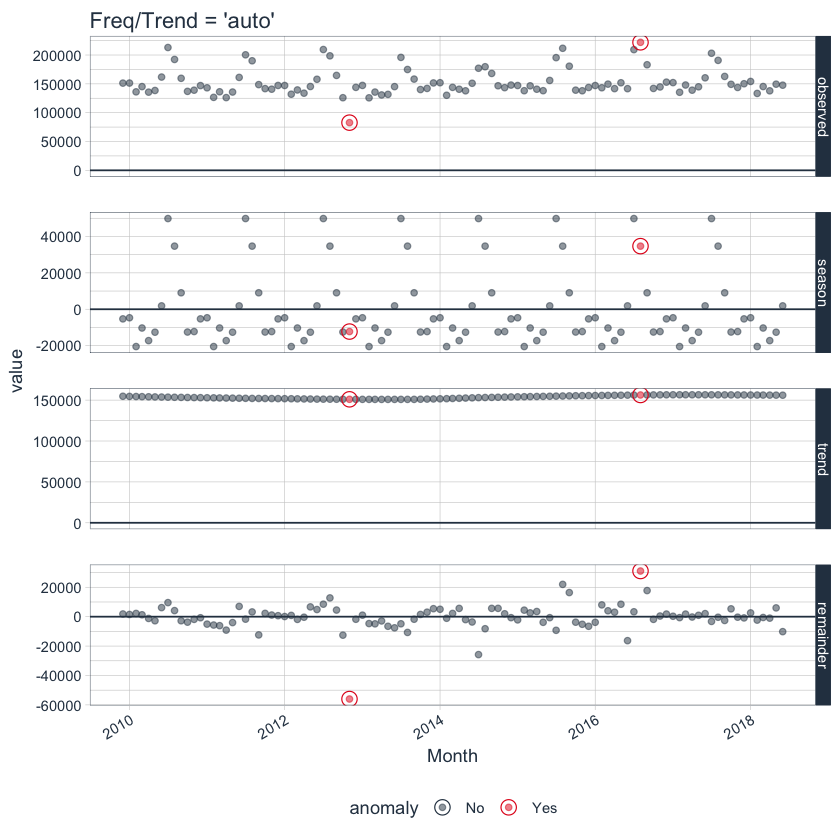

In [82]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

#### adjust the factors multiplied by IQR

In [83]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr', alpha = 0.025) %>%
    time_recompose()

# ts_anomalized %>% glimpse()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


By specifying the max number of outliers allowed, we get exactly the amount of outliers specified. The algorithm returns data points that have the largest absolute deviations in the residual component. 

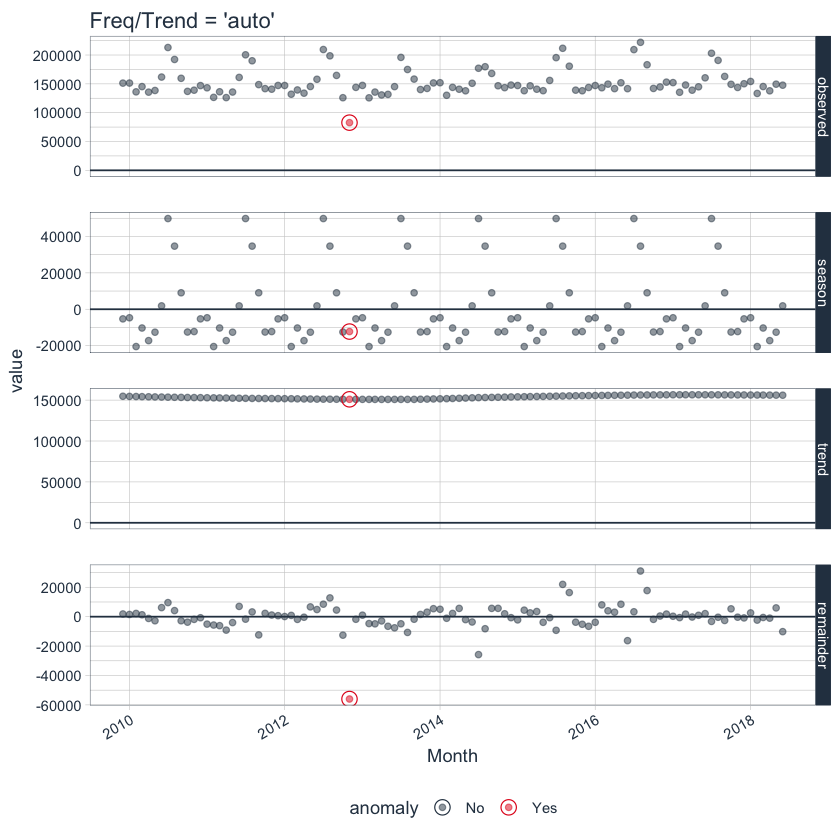

In [84]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

### Example 2 - Account with three missing values in the middle

#### Method: STL + IQR

In [85]:
ts =  select(filter(tb, Building_Meter == '164.0 - BLD 01_96973681'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = 'stl', merge = TRUE) %>%
    anomalize(remainder, method = 'iqr') %>%
    time_recompose()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


In [86]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,trend,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
164.0 - BLD 01_96973681,2012-11-01,64020.36,6.402036e+04,-3596.0013,97378.53,-29762.17,-23658.08,23760.54,Yes,70124.45,117543.1
164.0 - BLD 01_96973681,2013-01-01,0.00,-6.366463e-12,447.0866,97336.85,-97783.94,-23658.08,23760.54,Yes,74125.86,121544.5
164.0 - BLD 01_96973681,2013-02-01,0.00,1.818989e-12,-11446.9268,97316.01,-85869.08,-23658.08,23760.54,Yes,62211.00,109629.6
164.0 - BLD 01_96973681,2013-03-01,0.00,2.728484e-12,-5029.7667,97295.17,-92265.40,-23658.08,23760.54,Yes,68607.32,116025.9


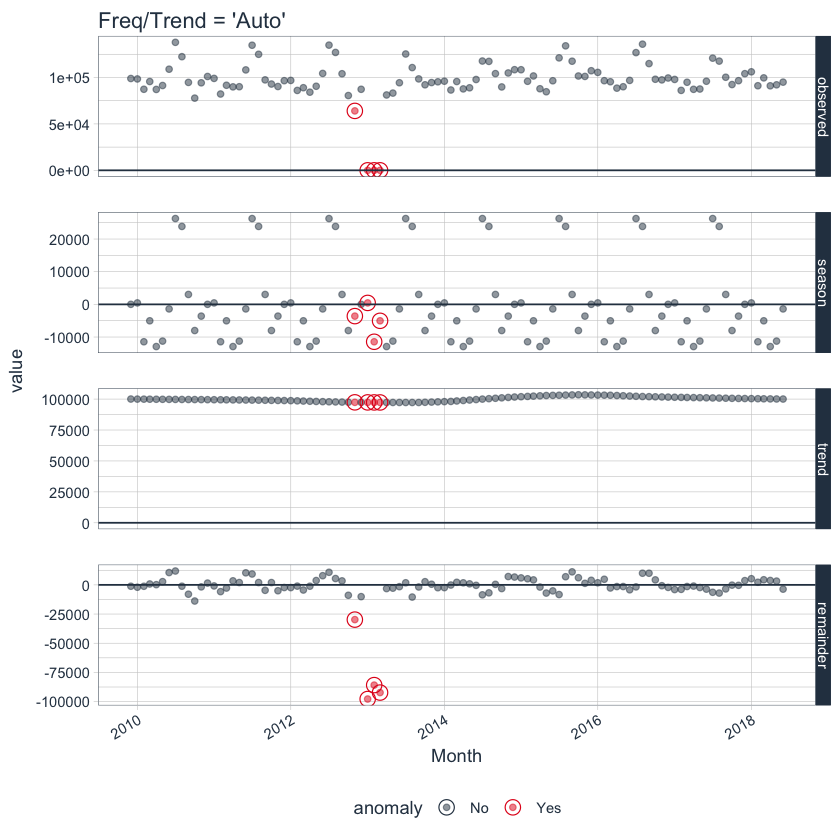

In [87]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'Auto'")

p1

#### Method: Twitter + GESD

In [88]:
ts =  select(filter(tb, Building_Meter == '164.0 - BLD 01_96973681'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = 'twitter', merge = TRUE) %>%
    anomalize(remainder, method = 'gesd') %>%
    time_recompose()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months


In [89]:
filter(ts_anomalized, anomaly == 'Yes')

Building_Meter,Month,Imputed_KWH,observed,season,median_spans,remainder,remainder_l1,remainder_l2,anomaly,recomposed_l1,recomposed_l2
164.0 - BLD 01_96973681,2012-11-01,64020.36,6.402036e+04,-3732.39396,94440,-26687.24,-12767.11,12767.11,Yes,77940.50,103474.71
164.0 - BLD 01_96973681,2013-01-01,0.00,1.918465e-12,78.54968,94440,-94518.55,-12767.11,12767.11,Yes,81751.44,107285.66
164.0 - BLD 01_96973681,2013-02-01,0.00,1.818989e-12,-11921.57764,94440,-82518.42,-12767.11,12767.11,Yes,69751.31,95285.53
164.0 - BLD 01_96973681,2013-03-01,0.00,9.094947e-13,-5461.12432,94440,-88978.88,-12767.11,12767.11,Yes,76211.77,101745.98


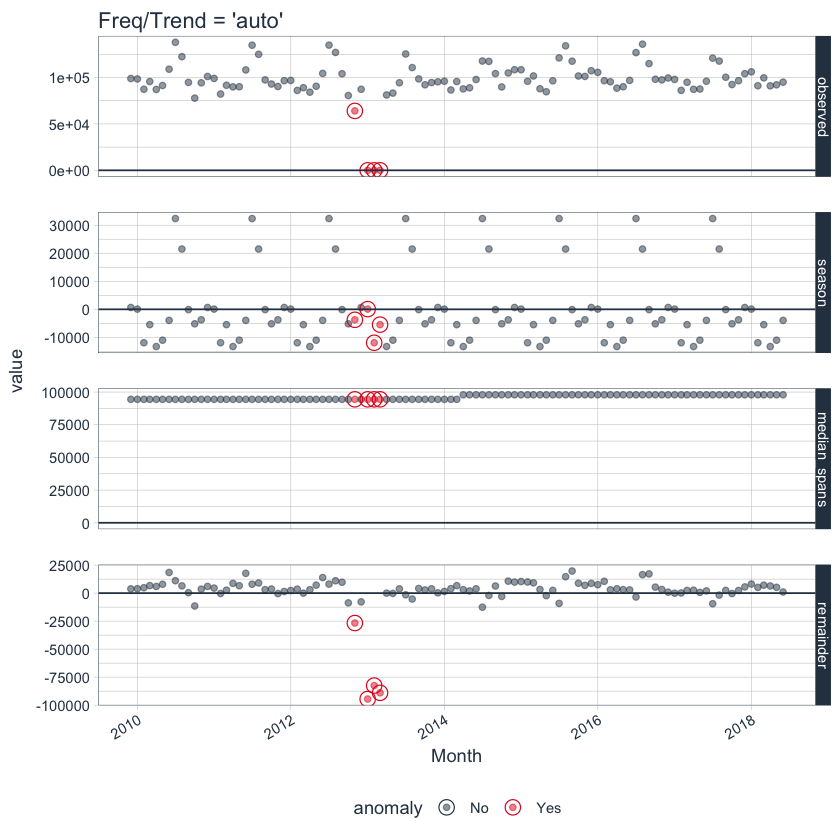

In [90]:
p1 <- ts_anomalized %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

## Loop through all accounts (with at least 3 years of data)

We can do the following parameters tuning for each account:
- Twitter vs. STL decomposition method
- IQR vs. GESD test on residuals
- max_anom for the upper limit of number of outliers
- others

For now, we just use the default setting and same parameter configurations for all accounts.

Only consider accounts with more than 50 months of data

In [95]:
accounts = tb %>% group_by(Building_Meter) %>% summarise(counts = n(), na_counts = sum(Imputed_KWH == 0))
accounts <- filter(accounts, counts - na_counts >= 50)
accounts <- mutate(accounts, na_perc = na_counts/counts)
dim(accounts)
summary(accounts$na_perc)

[1] 1916    4

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.02913 0.06762 0.09091 0.43750 

#### STL + IQR method

In [268]:
results_stl <- vector("list", length(accounts)) 

start.time <- Sys.time()

for (i in 1:length(accounts$Building_Meter)) {
# for (i in 1:2) {
    ts = select(filter(tb, Building_Meter == accounts$Building_Meter[[i]]), 'Month', 'Imputed_KWH')
    ts_anomalized <- ts %>%
        time_decompose(Imputed_KWH, merge = TRUE, method = 'stl') %>%
        anomalize(remainder, method = 'iqr', alpha = 0.025) %>%
#         anomalize(remainder) %>%
        time_recompose()
    ts_anomalized$Account = accounts$Building_Meter[[i]]
    results_stl[[i]] <- ts_anomalized
}

end.time <- Sys.time()
time.taken.stl <- end.time - start.time

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting

frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 26 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index 

trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freque

trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend 

frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 28 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 18 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 18 months
Converting

frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 30 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 49 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
fr

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 33 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 34 months
Converting

frequency = 12 months
trend = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 47.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freq

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 27 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 49 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting

frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 month

frequency = 12 months
trend = 15 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

frequency = 12 months
trend = 46.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 46.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 25 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 29 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freque

frequency = 12 months
trend = 37.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 37.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
freque

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 48.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 49 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converti

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 38.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Co

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 31.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 39 months
Conver

frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency 

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 40 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 27 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 4 months
Converting 

In [269]:
time.taken.stl

Time difference of 3.083374 mins

##### Summary of the % of anomalies detected

In [270]:
points = lapply(results_stl, function(i) nrow(i))
anoamly_counts = lapply(results_stl, function(i) nrow(filter(i, anomaly == 'Yes')))

In [271]:
summary_stl = tibble('account' = accounts$Building_Meter, 'points' = unlist(points), 'anomalies' = unlist(anoamly_counts))
summary_stl = mutate(summary_stl, anom_perc = anomalies / points)
summary(summary_stl$anom_perc)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.009709 0.029703 0.043791 0.067961 0.200000 

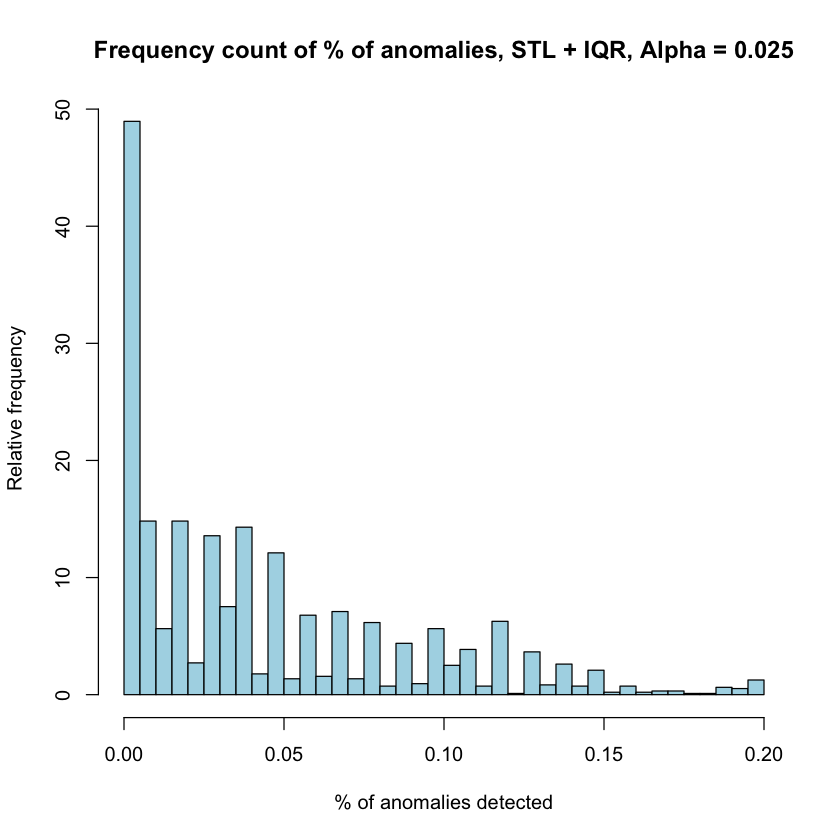

In [274]:
hist(summary_stl$anom_perc,
      main="Frequency count of % of anomalies, STL + IQR, Alpha = 0.025",
      xlab="% of anomalies detected",
      ylab="Relative frequency",
      breaks=50,
      col="lightblue",
      freq=FALSE)                            # freq=FALSE means to plot density, not counts
#       xaxt="yes")                              # xaxt="n" means "x axis tick marks == no"

#### Twitter + GESD method

In [275]:
results_twitter <- vector("list", length(accounts)) 

start.time <- Sys.time()

for (i in 1:length(accounts$Building_Meter)) {
# for (i in 1:2) {
    ts = select(filter(tb, Building_Meter == accounts$Building_Meter[[i]]), 'Month', 'Imputed_KWH')
    ts_anomalized <- ts %>%
        time_decompose(Imputed_KWH, merge = TRUE, method = 'twitter') %>%
        anomalize(remainder, method = 'gesd', alpha = 0.025) %>%
#         anomalize(remainder) %>%
        time_recompose()
    ts_anomalized$Account = accounts$Building_Meter[[i]]
    results_twitter[[i]] <- ts_anomalized
}

end.time <- Sys.time()
time.taken.twitter <- end.time - start.time

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 12 months
Converting from tbl_df to tbl_time.
Auto-index message: in

frequency = 12 months
median_span = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from 

frequency = 12 months
median_span = 36.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 26 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting f

frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converti

median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 35.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 36.5 months
Converting from tbl_df to tbl_time.


Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: inde

median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 32 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 35 months
Converting from tbl_df to tbl_time.


median_span = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: in

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 45.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index 

frequency = 12 months
median_span = 20.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 33 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting fro

frequency = 12 months
median_span = 15 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 8 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from

median_span = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 41 months
Converting from tbl_df to tbl_time.
Auto-index m

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 20.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: in

median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 11 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months
Converting from tbl_df to tbl_time

frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting

frequency = 12 months
median_span = 50.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converti

frequency = 12 months
median_span = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 40.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 15 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = 

frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46.5 months
Converting from 

frequency = 12 months
median_span = 36 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df

frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 44 months
Converting from tbl_df t

frequency = 12 months
median_span = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 43 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 42.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting

frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting

frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 46 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 50 months
Converting from tbl_df t

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: in

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 34 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Mont

frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 38 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 51.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 47.5 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
median_span = 49 months
Converting f

In [280]:
time.taken.twitter

Time difference of 3.044855 mins

##### Summary of the % of anomalies detected

In [281]:
points = lapply(results_twitter, function(i) nrow(i))
anoamly_counts = lapply(results_twitter, function(i) nrow(filter(i, anomaly == 'Yes')))

In [282]:
summary_twitter = tibble('account' = accounts$Building_Meter, 'points' = unlist(points), 'anomalies' = unlist(anoamly_counts))
summary_twitter = mutate(summary_twitter, anom_perc = anomalies / points)
summary(summary_twitter$anom_perc)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0495  0.1068  0.1058  0.1618  0.2000 

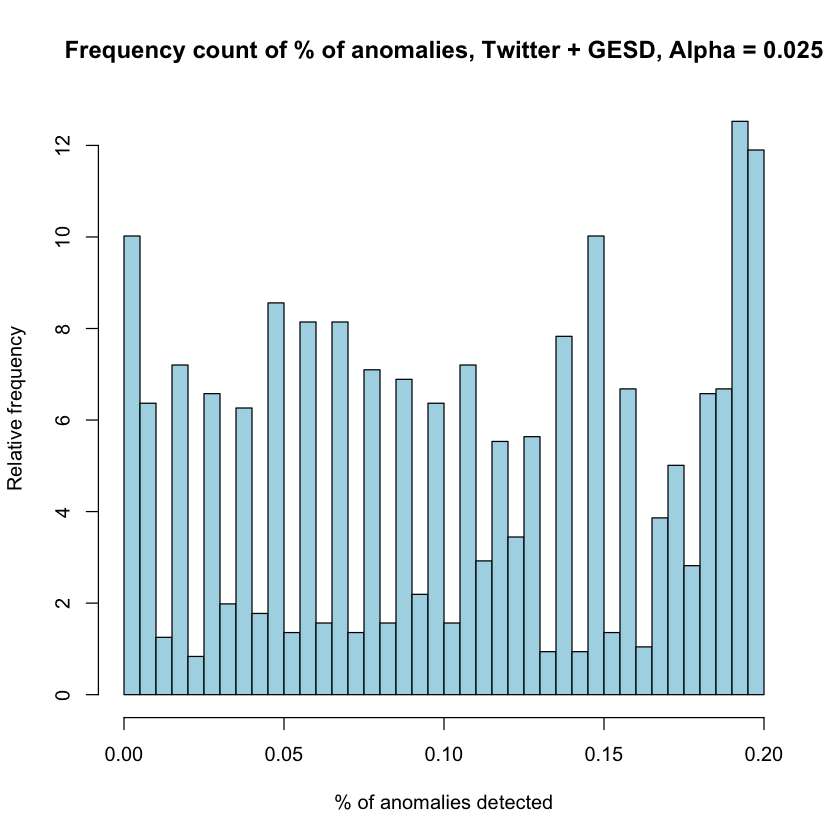

In [283]:
hist(summary_twitter$anom_perc,
      main="Frequency count of % of anomalies, Twitter + GESD, Alpha = 0.025",
      xlab="% of anomalies detected",
      ylab="Relative frequency",
      breaks=50,
      col="lightblue",
      freq=FALSE)                            # freq=FALSE means to plot density, not counts
#       xaxt="yes")                              # xaxt="n" means "x axis tick marks == no"

#### Comparing results from the two approaches

In [284]:
summary <- bind_cols(summary_stl, summary_twitter)

colnames(summary) <- c('account', 'points', 'anomalies_stl', 'anom_perc_stl', 'account', 'points1', 'anomalies_twitter', 'anom_perc_twitter')

summary <- summary[, c('account', 'points', 'anomalies_stl', 'anom_perc_stl', 'anomalies_twitter', 'anom_perc_twitter')]

summary <- mutate(summary, anom_perc_diff = (anomalies_stl - anomalies_twitter)/points)

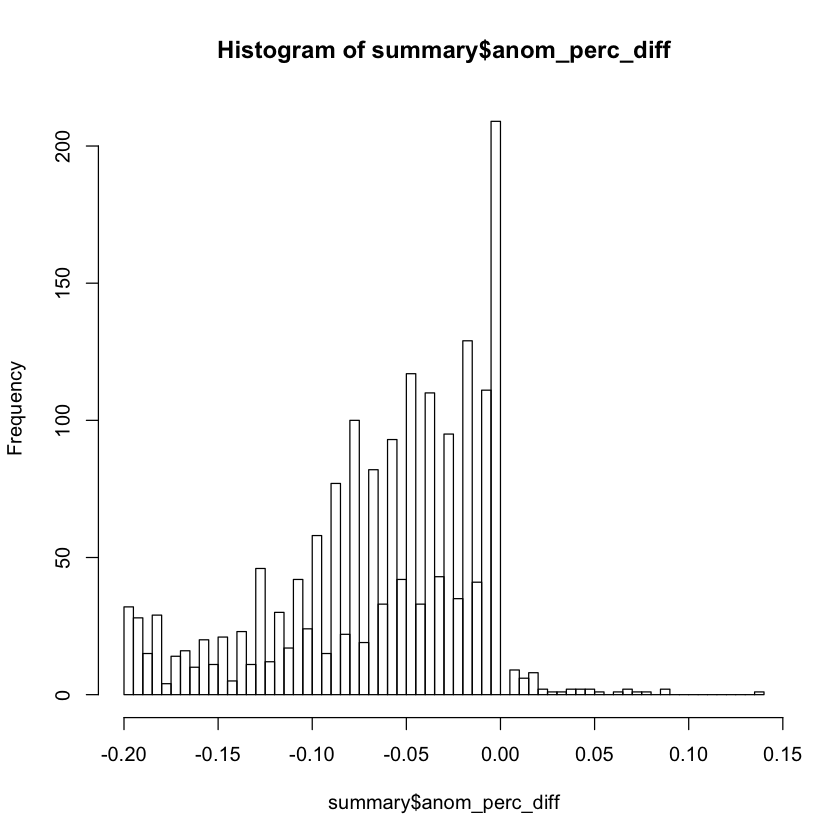

In [285]:
hist(summary$anom_perc_diff, breaks = 100)

In [286]:
head(filter(summary, anom_perc_diff > 0) %>% arrange(desc(anom_perc_diff)), 10)

account,points,anomalies_stl,anom_perc_stl,anomalies_twitter,anom_perc_twitter,anom_perc_diff
92.0 - BLD 20_6316120,65,13,0.20000000,4,0.06153846,0.13846154
337.0 - BLD 02_8076862,102,12,0.11764706,3,0.02941176,0.08823529
89.0 - BLD 02_8232066,68,10,0.14705882,4,0.05882353,0.08823529
502.0 - BLD 15_6316156,64,7,0.10937500,2,0.03125000,0.07812500
11.0 - CLASON POINT GARDENS BLD 44_8362632,96,19,0.19791667,12,0.12500000,0.07291667
377.0 - BLD 05_6707470,103,7,0.06796117,0,0.00000000,0.06796117
377.0 - BLD 07_7356333,103,7,0.06796117,0,0.00000000,0.06796117
92.0 - BLD 16_7161509,65,13,0.20000000,9,0.13846154,0.06153846
313.0 - BLD 03_7891030,95,6,0.06315789,1,0.01052632,0.05263158
181.0 - BLD 02_8545819,103,14,0.13592233,9,0.08737864,0.04854369


In [287]:
head(filter(summary, anom_perc_diff < 0) %>% arrange(desc(-anom_perc_diff)), 10)

account,points,anomalies_stl,anom_perc_stl,anomalies_twitter,anom_perc_twitter,anom_perc_diff
30.0 - BLD 04_8095311,60,0,0,12,0.2000000,-0.2000000
5.0 - QUEENSBRIDGE SOUTH BLD 08_8093903,70,0,0,14,0.2000000,-0.2000000
70.0 - BLD 04_8095176,85,0,0,17,0.2000000,-0.2000000
70.0 - BLD 08_8095184,85,0,0,17,0.2000000,-0.2000000
70.0 - BLD 14_8095174,85,0,0,17,0.2000000,-0.2000000
70.0 - BLD 15_8095171,85,0,0,17,0.2000000,-0.2000000
16.0 - BROWNSVILLE BLD 03_8322424,101,0,0,20,0.1980198,-0.1980198
16.0 - BROWNSVILLE BLD 07_8322437,101,0,0,20,0.1980198,-0.1980198
16.0 - BROWNSVILLE BLD 09_8095207,101,0,0,20,0.1980198,-0.1980198
16.0 - BROWNSVILLE BLD 13_8095216,101,0,0,20,0.1980198,-0.1980198


account,points,anomalies,anom_perc
89.0 - BLD 20_5537192,103,3,0.02912621


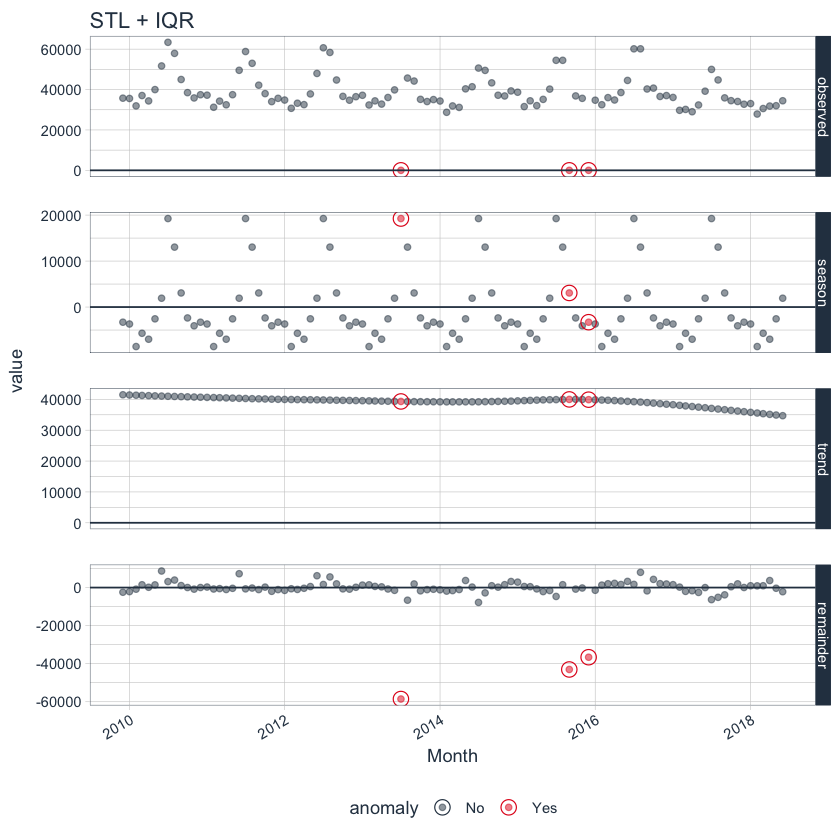

account,points,anomalies,anom_perc
89.0 - BLD 20_5537192,103,12,0.1165049


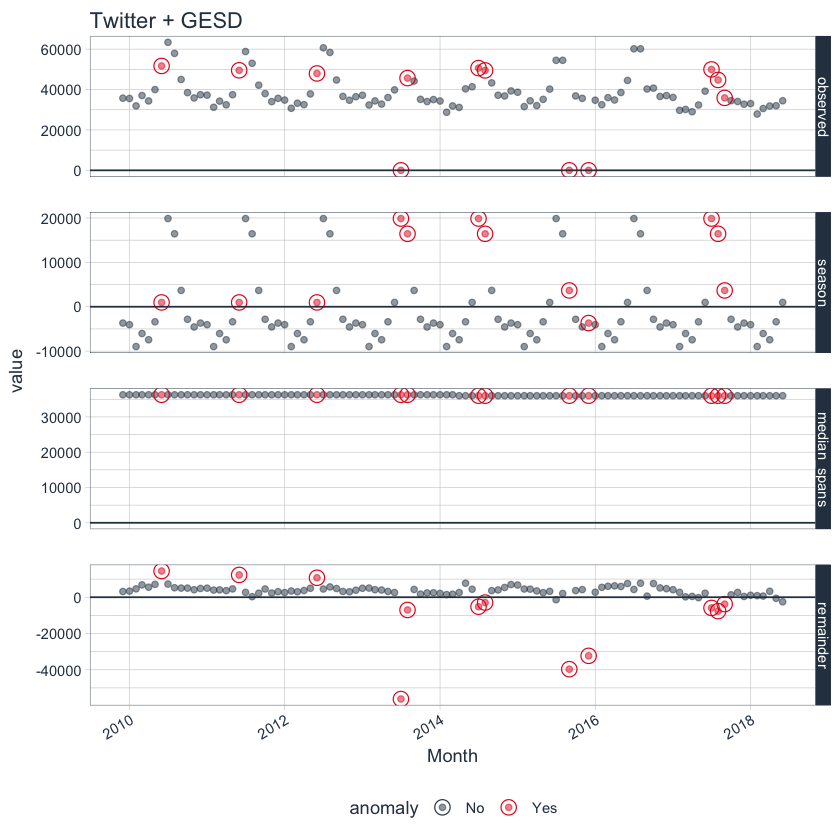

In [298]:
# i = match('89.0 - BLD 12_8232065', accounts$Building_Meter)
results_stl[[i]] %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("STL + IQR")
summary_stl[i, ]

results_twitter[[i]] %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Twitter + GESD")
summary_twitter[i, ]
i = i + 1

### Save the results into rdata files

##### default setting version 

In [267]:
results_stl.default <- results_stl
time.taken.stl.default <- time.taken.stl

results_twitter.default <- results_twitter
time.taken.twitter.default <- time.taken.twitter

summary.default <- summary

save(results_stl.default, time.taken.stl.default, results_twitter.default, time.taken.twitter.default, summary.default
     , file = "decomposition_results_default_setting.RData")

##### alpha = 0.025 version 

In [ ]:
results_stl.025 <- results_stl
time.taken.stl.025 <- time.taken.stl

results_twitter.025 <- results_twitter
time.taken.twitter.025 <- time.taken.twitter

summary.025 <- summary

save(results_stl.025, time.taken.stl.025, results_twitter.025, time.taken.twitter.025, summary.025
     , file = "decomposition_results_025.RData")

## Consider the case of level shifts
- Twitter + GESD is better than STL + IQR
- Should consider change level detection prior to decomposition

#### Level shift in the middle
- STL + IQR will bypass the middle level shift (can't detect the level change)
- Twitter + GESD treats all points at the shifted level as outliers

In [ ]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

idx_outliers <- seq(50, 70)
ts$Imputed_KWH[idx_outliers] <- ts$Imputed_KWH[idx_outliers] + mean(ts$Imputed_KWH)/2

ts_anomalized_twitter <- ts %>%
    time_decompose(Imputed_KWH, method = "Twitter", merge = TRUE) %>%
    anomalize(remainder, method = 'gesd', max_anoms = 20/nrow(ts) + (nrow(ts) - 20)/nrow(ts)) %>%
    time_recompose()

ts_anomalized_stl <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr', max_anoms = 20/nrow(ts) + (nrow(ts) - 20)/nrow(ts)) %>%
    time_recompose()

# ts_anomalized %>% glimpse()

In [ ]:
ts_anomalized_stl %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

In [ ]:
ts_anomalized_twitter %>%
    plot_anomalies(alpha_dots = 1) + geom_line()

#### Level shift in the end
- neither method perform well
- need to apply the decomposition on the two levels separately

In [ ]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

idx_outliers <- seq(50, length(ts))
ts$Imputed_KWH[idx_outliers] <- ts$Imputed_KWH[idx_outliers] + mean(ts$Imputed_KWH)/2

ts_anomalized_twitter <- ts %>%
    time_decompose(Imputed_KWH, method = "Twitter", merge = TRUE) %>%
    anomalize(remainder, method = 'gesd') %>%
    time_recompose()

ts_anomalized_stl <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr') %>%
    time_recompose()

# ts_anomalized %>% glimpse()

In [ ]:
ts_anomalized_twitter %>%
    plot_anomaly_decomposition(alpha_dot = 0.5)

In [ ]:
ts_anomalized_stl %>%
    plot_anomaly_decomposition(alpha_dot = 0.5)

## Testing the Anomalize package

#### Test 1 - Test the IQR test function (No issue)

In [ ]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'iqr') %>%
    time_recompose()

In [ ]:
filter(ts_anomalized, anomaly == 'Yes')

In [ ]:
outliers <- iqr(ts_anomalized$remainder, alpha = 0.05, max_anoms = 0.2, verbose = TRUE)$outlier_report


outliers

In [ ]:
# ploting function for anomaly plots
ggsetup <- function(data) {
    data %>%
        ggplot(aes(rank, value, color = outlier)) +
        geom_point() +
        geom_line(aes(y = limit_upper), color = "red", linetype = 2) +
        geom_line(aes(y = limit_lower), color = "red", linetype = 2) +
        geom_text(aes(label = index), vjust = -1.25) +
        theme_bw() +
        scale_color_manual(values = c("No" = "#2c3e50", "Yes" = "#e31a1c")) +
        expand_limits(y = 13) +
        theme(legend.position = "bottom")
}

p4 <- outliers %>% 
    ggsetup() +
    ggtitle("Top outlers sorted by rank") 

p4

#### End of test 1

#### Test 2-  Test the GESD function
- remainder_l1, remainder_l2, recomposed_l1, recomposed_l2 values are incorrect in the time_recompose returned tibble (they should vary however in the ts_anomalize tibble they remain constant as the bounds for the first non-anomaly data point)
- some remainder values fall within its reminder range but were still labeled as an anomaly (when STL + GESD is applied)

In [ ]:
ts =  select(filter(tb, Building_Meter == '165.0 - BLD 03_90327795'), 'Building_Meter', 'Month', 'Imputed_KWH')

ts_anomalized <- ts %>%
    time_decompose(Imputed_KWH, method = "STL", merge = TRUE) %>%
    anomalize(remainder, method = 'gesd') %>%
    time_recompose()

In [ ]:
ts_anomalized

In [ ]:
outliers <- anomalize::gesd(ts_anomalized$remainder, alpha = 0.05, max_anoms = 0.2, verbose = TRUE)$outlier_report

In [ ]:
filter(ts_anomalized, anomaly == 'Yes')

In [ ]:
outliers

In [ ]:
p4 <- outliers %>% 
    ggsetup() +
    ggtitle("Top outlers sorted by rank") 

p4

#### End of test2

## Conclusions
- The Twitter decomposition method works bette when a long-term trend is less dominant that the short-term seasonal component.
- Check the characteristics of the time series to decide which decomposition algorithm to apply
- Perform level-change, variance-change detections before applying the decomposition algorithm (need to learn the ecp or changepoint packages though)